In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

In [2]:
# Load the processed dataset
df_clean = pd.read_csv('churn_processed.csv')

# Separate features and target
X = df_clean.drop('Exited', axis=1)
y = df_clean['Exited']

# Split the data into training and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (7000, 14)
Test set shape: (3000, 14)


In [3]:
# Build a decision tree with default settings
dt_default = DecisionTreeClassifier(random_state=42)
dt_default.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [4]:
# Evaluate on training and test sets
y_train_pred = dt_default.predict(X_train)
y_test_pred = dt_default.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("\nDefault Decision Tree Performance:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Default Decision Tree Performance:
Training Accuracy: 0.9997
Test Accuracy: 0.9417


In [5]:
# Get feature importances
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': dt_default.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances.head(10))


Feature Importances:
             Feature  Importance
7   ComplaintsLodged    0.831229
10   EstimatedSalary    0.034434
2                Age    0.032082
0        CreditScore    0.031932
5            Balance    0.030601
4             Tenure    0.014164
6      NumOfProducts    0.010609
8          HasCrCard    0.003777
1                Sex    0.002801
9     IsActiveMember    0.002553


In [6]:
# Get tree information
n_nodes = dt_default.tree_.node_count
n_leaves = dt_default.tree_.n_leaves
max_depth = dt_default.tree_.max_depth

print("\nTree Information:")
print(f"Number of nodes: {n_nodes}")
print(f"Number of leaves: {n_leaves}")
print(f"Number of rules: {n_leaves}")  # Each leaf corresponds to a decision rule
print(f"Maximum depth: {max_depth}")


Tree Information:
Number of nodes: 583
Number of leaves: 292
Number of rules: 292
Maximum depth: 17


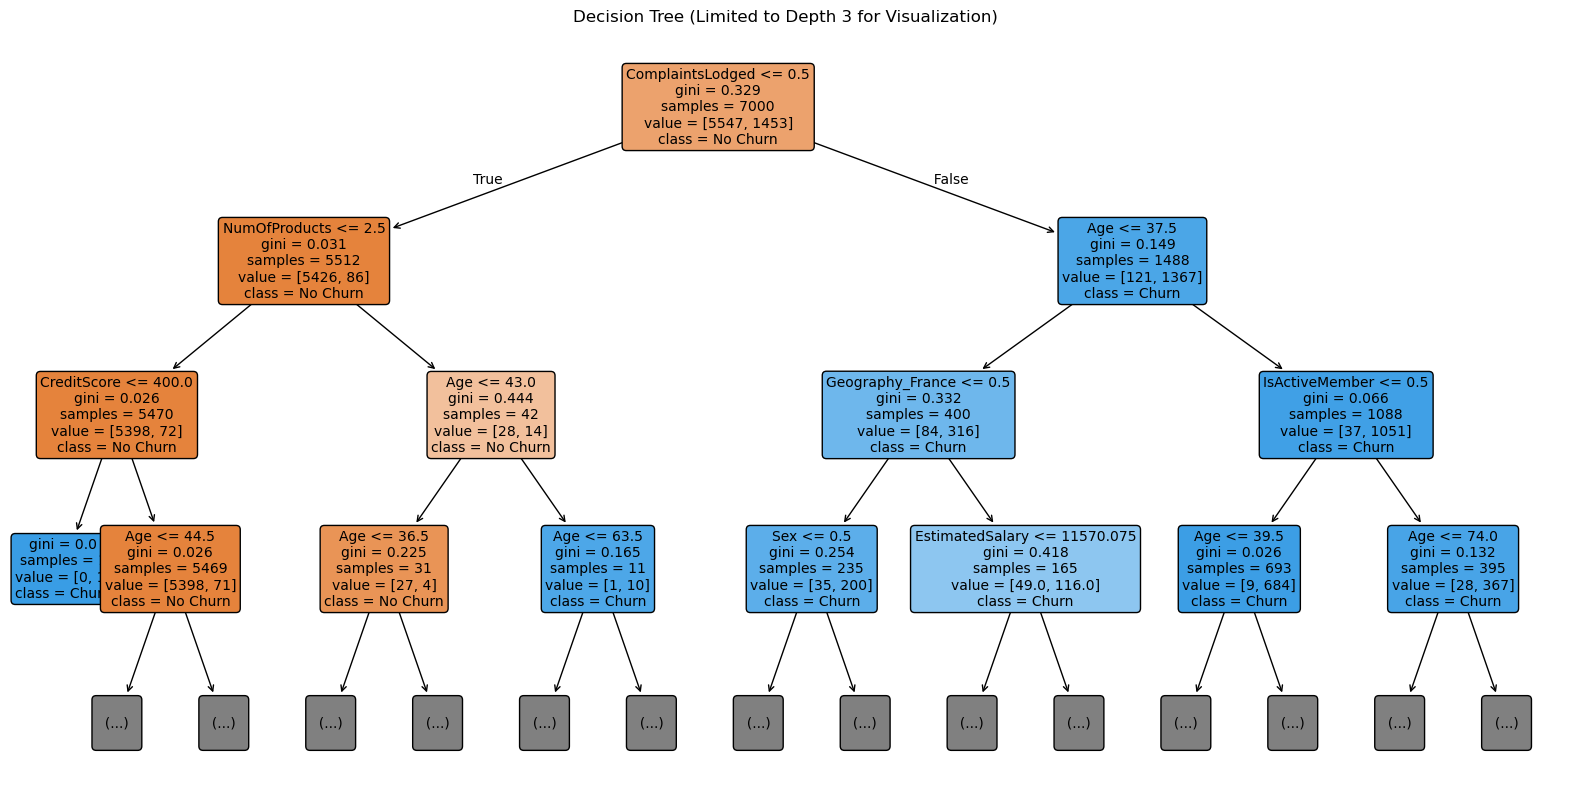

In [7]:
# Plot the decision tree (limited to max_depth=3 for visualization)
plt.figure(figsize=(20, 10))
plot_tree(dt_default, max_depth=3, feature_names=X.columns, class_names=['No Churn', 'Churn'], 
          filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree (Limited to Depth 3 for Visualization)")
plt.show()

In [8]:
# Get the first split feature
first_split_feature = X.columns[dt_default.tree_.feature[0]]
print(f"\nFirst split feature: {first_split_feature}")

# Get the second split features (there can be two second splits)
left_child_idx = dt_default.tree_.children_left[0]
right_child_idx = dt_default.tree_.children_right[0]
left_split_feature = X.columns[dt_default.tree_.feature[left_child_idx]] if left_child_idx != -1 else "None"
right_split_feature = X.columns[dt_default.tree_.feature[right_child_idx]] if right_child_idx != -1 else "None"

print(f"Second split features: {left_split_feature} (left branch) and {right_split_feature} (right branch)")



First split feature: ComplaintsLodged
Second split features: NumOfProducts (left branch) and Age (right branch)


In [9]:
# Check for overfitting by comparing training and test accuracy
print("\nOverfitting Check:")
print(f"Accuracy difference (Train - Test): {train_accuracy - test_accuracy:.4f}")
if train_accuracy - test_accuracy > 0.05:
    print("Possible overfitting: Training accuracy is higher than test accuracy")
else:
    print("No strong evidence of overfitting: Training and test accuracies are similar")


Overfitting Check:
Accuracy difference (Train - Test): 0.0580
Possible overfitting: Training accuracy is higher than test accuracy


In [10]:
# Explanation of hyperparameters:
# - max_depth: Maximum depth of the tree (None means unlimited)
# - min_samples_split: Minimum samples required to split a node
# - min_samples_leaf: Minimum samples required at a leaf node
# - criterion: Function to measure the quality of a split (gini or entropy)

# Define the parameter grid to search
param_grid = {
    'max_depth': [3, 5, 7, 9, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'criterion': ['gini', 'entropy']
}

In [28]:
# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,                    # 5-fold cross-validation
    scoring='accuracy',      # Use accuracy as the scoring metric
    n_jobs=-1,               # Use all available CPU cores
    verbose=1                # Show progress
)

In [30]:
# Perform the grid search
print("Starting Grid Search for Decision Tree optimization...")
grid_search.fit(X_train, y_train)

# Get the best parameters and best estimator
print("\nBest Parameters:")
print(grid_search.best_params_)

# Use the best model
dt_best = grid_search.best_estimator_

Starting Grid Search for Decision Tree optimization...
Fitting 5 folds for each of 160 candidates, totalling 800 fits

Best Parameters:
{'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [32]:
# Evaluate on training and test sets
y_train_pred_best = dt_best.predict(X_train)
y_test_pred_best = dt_best.predict(X_test)

train_accuracy_best = accuracy_score(y_train, y_train_pred_best)
test_accuracy_best = accuracy_score(y_test, y_test_pred_best)

print("\nOptimized Decision Tree Performance:")
print(f"Training Accuracy: {train_accuracy_best:.4f}")
print(f"Test Accuracy: {test_accuracy_best:.4f}")


Optimized Decision Tree Performance:
Training Accuracy: 0.9717
Test Accuracy: 0.9653


In [34]:
# Get feature importances
feature_importances_best = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': dt_best.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances_best.head(10))


Feature Importances:
                Feature  Importance
7      ComplaintsLodged    0.951731
2                   Age    0.022453
6         NumOfProducts    0.021485
9        IsActiveMember    0.004330
0           CreditScore    0.000000
1                   Sex    0.000000
3  CurrentWorkingStatus    0.000000
4                Tenure    0.000000
5               Balance    0.000000
8             HasCrCard    0.000000


In [36]:
# Get tree information
n_nodes_best = dt_best.tree_.node_count
n_leaves_best = dt_best.tree_.n_leaves
max_depth_best = dt_best.tree_.max_depth

print("\nTree Information:")
print(f"Number of nodes: {n_nodes_best}")
print(f"Number of leaves: {n_leaves_best}")
print(f"Number of rules: {n_leaves_best}")  # Each leaf corresponds to a decision rule
print(f"Maximum depth: {max_depth_best}")


Tree Information:
Number of nodes: 15
Number of leaves: 8
Number of rules: 8
Maximum depth: 3


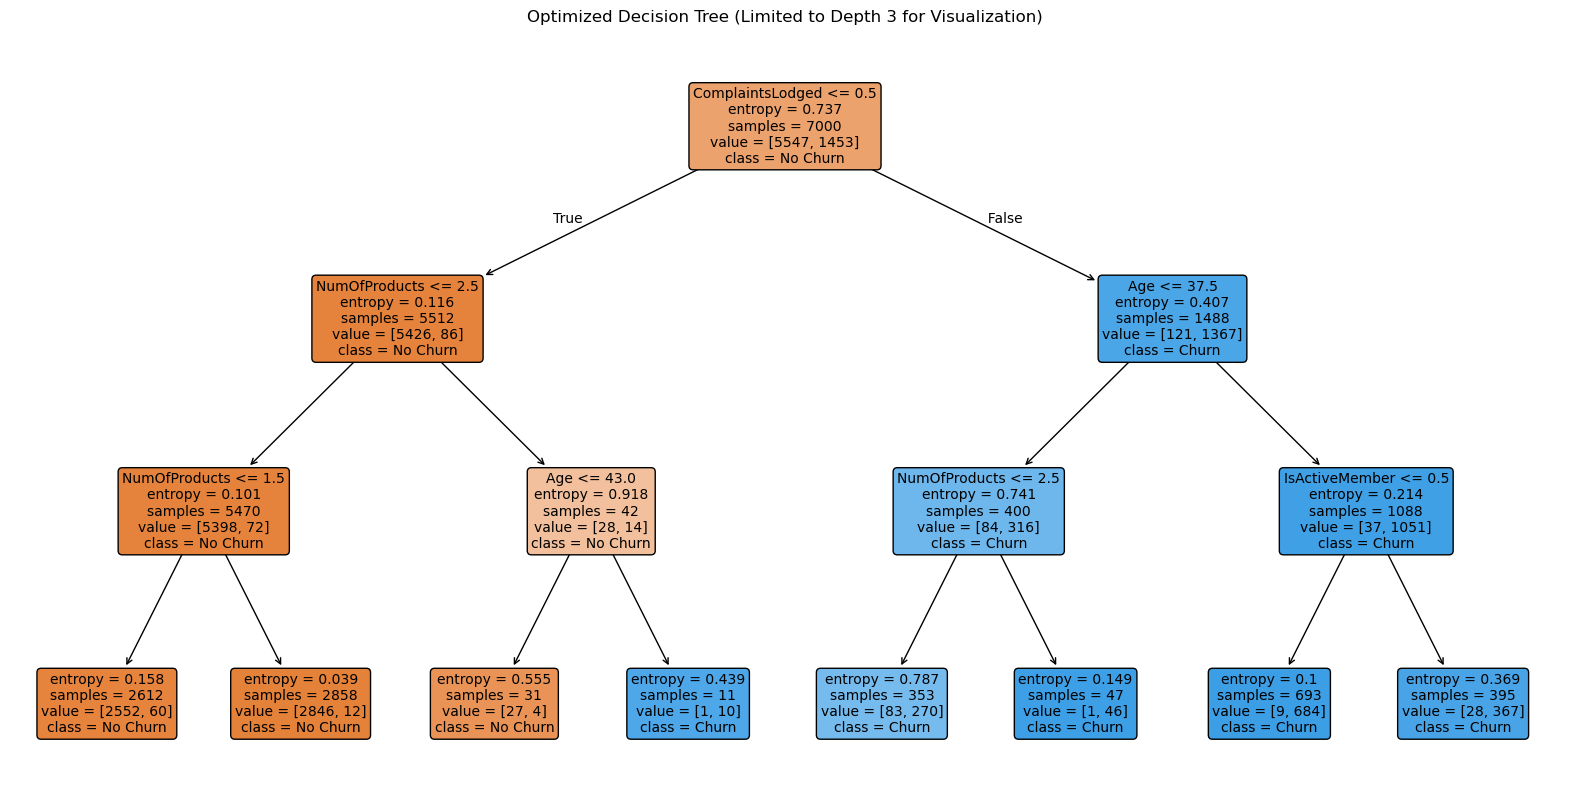

In [38]:
# Plot the decision tree (limited to max_depth=3 for visualization)
plt.figure(figsize=(20, 10))
plot_tree(dt_best, max_depth=3, feature_names=X.columns, class_names=['No Churn', 'Churn'], 
          filled=True, rounded=True, fontsize=10)
plt.title("Optimized Decision Tree (Limited to Depth 3 for Visualization)")
plt.show()


In [40]:
# Get the first split feature
first_split_feature_best = X.columns[dt_best.tree_.feature[0]]
print(f"\nFirst split feature: {first_split_feature_best}")

# Get the second split features (there can be two second splits)
left_child_idx_best = dt_best.tree_.children_left[0]
right_child_idx_best = dt_best.tree_.children_right[0]
left_split_feature_best = X.columns[dt_best.tree_.feature[left_child_idx_best]] if left_child_idx_best != -1 else "None"
right_split_feature_best = X.columns[dt_best.tree_.feature[right_child_idx_best]] if right_child_idx_best != -1 else "None"

print(f"Second split features: {left_split_feature_best} (left branch) and {right_split_feature_best} (right branch)")



First split feature: ComplaintsLodged
Second split features: NumOfProducts (left branch) and Age (right branch)


In [42]:
# Check for overfitting by comparing training and test accuracy
print("\nOverfitting Check:")
print(f"Accuracy difference (Train - Test): {train_accuracy_best - test_accuracy_best:.4f}")
if train_accuracy_best - test_accuracy_best > 0.05:
    print("Possible overfitting: Training accuracy is significantly higher than test accuracy")
else:
    print("No strong evidence of overfitting: Training and test accuracies are similar")


Overfitting Check:
Accuracy difference (Train - Test): 0.0064
No strong evidence of overfitting: Training and test accuracies are similar
